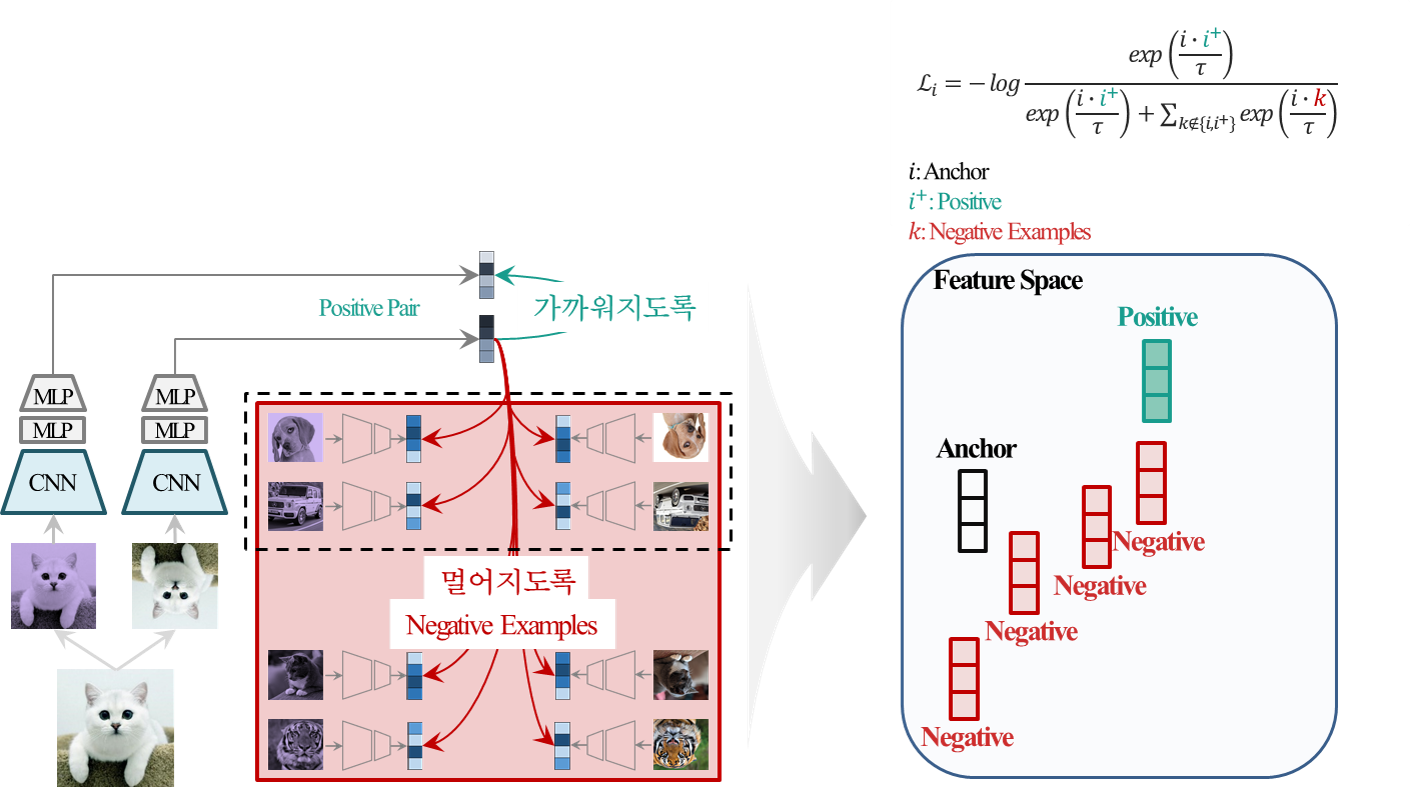

In [33]:
from IPython.display import Image
Image('./simclr.png')

# 필요한 패키지 불러오기

In [34]:
import os
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models

from torch.utils.data import Dataset
from torchvision.transforms import transforms
from torchvision import transforms, datasets

import warnings
warnings.filterwarnings(action='ignore')

# 학습에 필요한 하이퍼파라미터 정의

In [52]:
ARCHITECTURE = 'resnet18'
MLP_HIDDEN_SIZE = 512
PROJECTION_SIZE = 128
NUM_WORKER = 0
N_VIEWS = 2
EPOCHS = 5
BATCH_SIZE = 256
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
SEED = 123
NUM_CLASS = 10
LOG_EVERY_N_STEPS = 20
TEMPERATURE = 0.07
GPU_INDEX = 0
DEVICE = 'cuda'

# CIFAR10 Dataset 정의

In [36]:
class CIFAR10Dataset(Dataset):
    def __init__(self, 
                 data_dir: str = './data',
                 mode: str = 'train'):
        
        self.data_dir = data_dir
        self.mode = mode
        
        # 저장 경로 폴더 없을 때 만들기
        os.makedirs(data_dir, exist_ok=True)
    
    @staticmethod
    def get_transform(size: int = None,
                      s: int = 1):
        """
        Return a set of data augmentation transformations 
        as described in the SimCLR paper.
        """
        
        normalize = transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010))
        color_jitter = transforms.ColorJitter(0.8 * s, 
                                              0.8 * s,
                                              0.8 * s,
                                              0.2 * s)
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(kernel_size=int(0.1 * size)),
            transforms.ToTensor(),
            normalize,
        ])
        
        return data_transforms
    
    # For SimCLR 
    def get_pretrain_dataset(self, n_views: int = 2):        
        # SimCLR, 지도 학습에 사용되는 학습 데이터
        
        if self.mode == 'train':
            train_dataset = datasets.CIFAR10(self.data_dir,
                                             train=True,
                                             transform=ViewGenerator(
                                                 base_transform=self.get_transform(size=32),
                                                 n_views=n_views),
                                             download=True)
            
            return train_dataset
        
        else:
            raise NotImplementedError()
    
    # For Supervised Setting (Transfer Learning)
    def get_dataset(self):        
        # SimCLR, 지도 학습에 사용되는 학습 데이터
        
        if self.mode == 'train':
            train_dataset = datasets.CIFAR10(self.data_dir,
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
            
            return train_dataset
        
        elif self.mode == 'test':
            # 지도 학습 테스트에 사용되는 테스트 데이터
            test_dataset = datasets.CIFAR10(self.data_dir,
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=False)
            
            return test_dataset
        
        else:
            raise NotImplementedError()
            

class GaussianBlur(object):
    """
    blur a single image on CPU
    """
    def __init__(self, kernel_size: int = None):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(in_channels=3,
                                out_channels=3,
                                kernel_size=(kernel_size, 1),
                                stride=1,
                                padding=0, 
                                bias=False,
                                groups=3)
        self.blur_v = nn.Conv2d(in_channels=3,
                                out_channels=3,
                                kernel_size=(1, kernel_size),
                                stride=1,
                                padding=0, 
                                bias=False,
                                groups=3)
        self.k = kernel_size
        self.r = radias
        
        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )
        
        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()
    
    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)
        
        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)
        
        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))
    
        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()
        
        img = self.tensor_to_pil(img)
        
        return img
    
    
class ViewGenerator(object):
    """
    Take two random crops of one image as the query and key.
    """
    
    def __init__(self,
                 base_transform,
                 n_views: int = 2):
        
        self.base_transform = base_transform
        self.n_views = n_views
    
    def __call__(self, x):
        
        return [self.base_transform(x) for i in range(self.n_views)]

# 학습 네트워크 정의

In [49]:
class ResNet(nn.Module):
    def __init__(self, base_model: str = None):
        super(ResNet, self).__init__()
        
        self.resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),
            'resnet50': models.resnet50(pretrained=False)
        }
        
        resnet = self.get_basemodel(base_model)
        
        # Define CNN encoder
        self.encoder = nn.Sequential(
            *list(resnet.children())[:-1])
        
        # Define MLP Projection
        self.projection = MLPHead(in_channels=resnet.fc.in_features,
                                  mlp_hidden_size=MLP_HIDDEN_SIZE,
                                  projection_size=PROJECTION_SIZE)
    
    def forward(self, x: torch.Tensor):
        h = self.encoder(x)
        h = h.view(h.shape[0], h.shape[1])
        
        return self.projection(h)
    
    def get_basemodel(self, model_name: str = None):
 
        model = self.resnet_dict[model_name]

        return model
    

class MLPHead(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 mlp_hidden_size: int,
                 projection_size):
        super(MLPHead, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, mlp_hidden_size), 
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_size, projection_size)
        )
    
    def forward(self, x):
        
        return self.mlp(x)

# 평가 지표 및 SimCLR 학습 정의

In [50]:
def accuracy(output: torch.FloatTensor, 
             target: torch.LongTensor, 
             topk: tuple = (1, )):
    """
    Computes the accuracy over the k top predictions
    for the specified values of k.
    """
    
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res
        

class SimCLR(object):
    def __init__(self, **kwargs):
        self.model = kwargs['model'].to(DEVICE)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        self.criterion = nn.CrossEntropyLoss().to(DEVICE)
    
    def infonce(self, 
                features: torch.FloatTensor,
                n_views: int = 2):
        
        # 0, 1, ..., BATCH_SIZE
        labels = torch.cat([torch.arange(BATCH_SIZE) for i in range(n_views)], dim=0)
        
        # 동일한 값 기준으로 0, 1 행렬 표현
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(DEVICE)
        
        # Normalize Feature Vector
        features = F.normalize(features, dim=1)
        
        # 정규화된 벡터 간 행렬 곱
        similarity_matrix = torch.matmul(features, features.T)
        
        # labels matrix, similarity matrix에서 main diagonal 지우기 (대각 행렬 값 0으로)
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(DEVICE)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        
        # Select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
        
        # Select only the negatives
        negatives = similarity_matrix[~labels.bool()].view(labels.shape[0], -1)
        
        logits = torch.cat([positives, negatives], dim=1)  # 한 배치마다 positive가 0 index에 존재
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)  # 0은 positive 클래스를 의미
        
        logits = logits / TEMPERATURE
        
        return logits, labels
    
    def train(self, train_loader):
        
        n_iter = 0
        for epoch in range(EPOCHS):
            
            train_loss = 0
            for images, _ in tqdm(train_loader):
                images = torch.cat(images, dim=0)  # 2 * Batch Size
                images = images.to(DEVICE)
                
                features = self.model(images)
                logits, labels = self.infonce(features=features)
                loss = self.criterion(logits, labels)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss
                
                if n_iter % LOG_EVERY_N_STEPS == 0:
                    top1, top5 = accuracy(logits, labels, topk=(1, 5))
                    print(f'Loss: {loss} \n'
                          f'ACC/Top1: {top1[0]} \n'
                          f'ACC/Top5: {top5[0]} \n'
                          f'Learning Rate: {self.scheduler.get_lr()[0]}')
                
                n_iter += 1
            
            train_loss /= (len(train_loader))
            
            # Warmup for the first 10 epochs
            if epoch >= 10:
                self.scheduler.step()
                
            print('=' * 30)
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Top1 Accuracy: {top1[0]} \n'
                  f'Top5 Accuracy: {top5[0]} \n'
                  f'Learning Rate: {self.scheduler.get_lr()[0]}')
            
        return self.model               

# SimCLR 코드 실행

In [53]:
def main():
    
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    
    # Define Dataset, Dataloader
    dataset = CIFAR10Dataset(mode='train')
    
    train_dataset = dataset.get_pretrain_dataset(n_views=N_VIEWS)
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKER,
        drop_last=True)
    
    # Define Model, optimizer, scheduler
    model = ResNet(
        base_model=ARCHITECTURE)
    
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=LEARNING_RATE, 
        weight_decay=WEIGHT_DECAY)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer,
        T_max=len(train_loader),
        eta_min=0,
        last_epoch=-1)
    
    with torch.cuda.device(GPU_INDEX):
        simclr = SimCLR(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler)
        
        pretrained_model = simclr.train(train_loader=train_loader)
    
    return pretrained_model


if __name__ == '__main__':
    pretrained_model = main()

Files already downloaded and verified


  1%|▍                                                                                 | 1/195 [00:00<02:53,  1.12it/s]

Loss: 6.58261775970459 
ACC/Top1: 0.78125 
ACC/Top5: 2.34375 
Learning Rate: 0.0003


 11%|████████▋                                                                        | 21/195 [00:16<02:21,  1.23it/s]

Loss: 6.117272853851318 
ACC/Top1: 1.7578125 
ACC/Top5: 4.8828125 
Learning Rate: 0.0003


 21%|█████████████████                                                                | 41/195 [00:32<02:01,  1.27it/s]

Loss: 5.9078369140625 
ACC/Top1: 1.953125 
ACC/Top5: 6.0546875 
Learning Rate: 0.0003


 31%|█████████████████████████▎                                                       | 61/195 [00:48<01:47,  1.25it/s]

Loss: 5.764667510986328 
ACC/Top1: 1.7578125 
ACC/Top5: 7.2265625 
Learning Rate: 0.0003


 42%|█████████████████████████████████▋                                               | 81/195 [01:04<01:30,  1.25it/s]

Loss: 5.754995346069336 
ACC/Top1: 2.1484375 
ACC/Top5: 6.8359375 
Learning Rate: 0.0003


 52%|█████████████████████████████████████████▍                                      | 101/195 [01:20<01:16,  1.22it/s]

Loss: 5.873078346252441 
ACC/Top1: 2.734375 
ACC/Top5: 7.03125 
Learning Rate: 0.0003


 62%|█████████████████████████████████████████████████▋                              | 121/195 [01:35<00:56,  1.32it/s]

Loss: 5.538834571838379 
ACC/Top1: 4.296875 
ACC/Top5: 11.1328125 
Learning Rate: 0.0003


 72%|█████████████████████████████████████████████████████████▊                      | 141/195 [01:50<00:41,  1.31it/s]

Loss: 5.6457343101501465 
ACC/Top1: 1.3671875 
ACC/Top5: 7.8125 
Learning Rate: 0.0003


 83%|██████████████████████████████████████████████████████████████████              | 161/195 [02:05<00:28,  1.21it/s]

Loss: 5.543956279754639 
ACC/Top1: 5.078125 
ACC/Top5: 16.2109375 
Learning Rate: 0.0003


 93%|██████████████████████████████████████████████████████████████████████████▎     | 181/195 [02:21<00:11,  1.23it/s]

Loss: 5.503957271575928 
ACC/Top1: 4.1015625 
ACC/Top5: 12.890625 
Learning Rate: 0.0003


  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 1 
Loss: 5.747150421142578 
Top1 Accuracy: 4.1015625 
Top5 Accuracy: 12.890625 
Learning Rate: 0.0003


  3%|██▌                                                                               | 6/195 [00:04<02:33,  1.23it/s]

Loss: 5.515243053436279 
ACC/Top1: 5.6640625 
ACC/Top5: 15.234375 
Learning Rate: 0.0003


 13%|██████████▊                                                                      | 26/195 [00:20<02:09,  1.30it/s]

Loss: 5.38686466217041 
ACC/Top1: 6.640625 
ACC/Top5: 16.015625 
Learning Rate: 0.0003


 24%|███████████████████                                                              | 46/195 [00:35<01:51,  1.34it/s]

Loss: 5.286107063293457 
ACC/Top1: 6.4453125 
ACC/Top5: 15.8203125 
Learning Rate: 0.0003


 34%|███████████████████████████▍                                                     | 66/195 [00:50<01:37,  1.33it/s]

Loss: 5.376415252685547 
ACC/Top1: 5.859375 
ACC/Top5: 17.578125 
Learning Rate: 0.0003


 44%|███████████████████████████████████▋                                             | 86/195 [01:05<01:24,  1.29it/s]

Loss: 5.33419942855835 
ACC/Top1: 6.4453125 
ACC/Top5: 15.8203125 
Learning Rate: 0.0003


 54%|███████████████████████████████████████████▍                                    | 106/195 [01:20<01:06,  1.34it/s]

Loss: 5.2900848388671875 
ACC/Top1: 8.3984375 
ACC/Top5: 17.7734375 
Learning Rate: 0.0003


 65%|███████████████████████████████████████████████████▋                            | 126/195 [01:35<00:55,  1.25it/s]

Loss: 5.174267292022705 
ACC/Top1: 8.203125 
ACC/Top5: 21.09375 
Learning Rate: 0.0003


 75%|███████████████████████████████████████████████████████████▉                    | 146/195 [01:52<00:40,  1.22it/s]

Loss: 5.199078559875488 
ACC/Top1: 7.8125 
ACC/Top5: 20.8984375 
Learning Rate: 0.0003


 85%|████████████████████████████████████████████████████████████████████            | 166/195 [02:08<00:23,  1.23it/s]

Loss: 5.119956970214844 
ACC/Top1: 10.15625 
ACC/Top5: 21.6796875 
Learning Rate: 0.0003


 95%|████████████████████████████████████████████████████████████████████████████▎   | 186/195 [02:23<00:06,  1.31it/s]

Loss: 5.239503383636475 
ACC/Top1: 8.7890625 
ACC/Top5: 19.53125 
Learning Rate: 0.0003


  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 2 
Loss: 5.271181583404541 
Top1 Accuracy: 8.7890625 
Top5 Accuracy: 19.53125 
Learning Rate: 0.0003


  6%|████▌                                                                            | 11/195 [00:08<02:23,  1.28it/s]

Loss: 5.067042350769043 
ACC/Top1: 13.28125 
ACC/Top5: 26.3671875 
Learning Rate: 0.0003


 16%|████████████▉                                                                    | 31/195 [00:23<02:14,  1.22it/s]

Loss: 5.025387287139893 
ACC/Top1: 8.59375 
ACC/Top5: 21.484375 
Learning Rate: 0.0003


 26%|█████████████████████▏                                                           | 51/195 [00:40<01:58,  1.22it/s]

Loss: 5.036914825439453 
ACC/Top1: 9.375 
ACC/Top5: 20.703125 
Learning Rate: 0.0003


 36%|█████████████████████████████▍                                                   | 71/195 [00:56<01:44,  1.19it/s]

Loss: 5.040965557098389 
ACC/Top1: 10.7421875 
ACC/Top5: 26.171875 
Learning Rate: 0.0003


 47%|█████████████████████████████████████▊                                           | 91/195 [01:13<01:24,  1.23it/s]

Loss: 4.914870738983154 
ACC/Top1: 12.6953125 
ACC/Top5: 26.7578125 
Learning Rate: 0.0003


 57%|█████████████████████████████████████████████▌                                  | 111/195 [01:29<01:09,  1.22it/s]

Loss: 4.8163251876831055 
ACC/Top1: 15.0390625 
ACC/Top5: 28.3203125 
Learning Rate: 0.0003


 67%|█████████████████████████████████████████████████████▋                          | 131/195 [01:45<00:52,  1.21it/s]

Loss: 4.853879928588867 
ACC/Top1: 10.7421875 
ACC/Top5: 27.9296875 
Learning Rate: 0.0003


 77%|█████████████████████████████████████████████████████████████▉                  | 151/195 [02:01<00:35,  1.23it/s]

Loss: 5.182916164398193 
ACC/Top1: 11.71875 
ACC/Top5: 25.78125 
Learning Rate: 0.0003


 88%|██████████████████████████████████████████████████████████████████████▏         | 171/195 [02:18<00:20,  1.20it/s]

Loss: 4.882333755493164 
ACC/Top1: 13.4765625 
ACC/Top5: 28.3203125 
Learning Rate: 0.0003


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 191/195 [02:34<00:03,  1.25it/s]

Loss: 4.732235908508301 
ACC/Top1: 15.8203125 
ACC/Top5: 32.2265625 
Learning Rate: 0.0003


  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 3 
Loss: 4.986968517303467 
Top1 Accuracy: 15.8203125 
Top5 Accuracy: 32.2265625 
Learning Rate: 0.0003


  8%|██████▋                                                                          | 16/195 [00:11<02:17,  1.30it/s]

Loss: 4.6796674728393555 
ACC/Top1: 17.3828125 
ACC/Top5: 33.0078125 
Learning Rate: 0.0003


 18%|██████████████▉                                                                  | 36/195 [00:24<01:49,  1.45it/s]

Loss: 4.790319442749023 
ACC/Top1: 14.2578125 
ACC/Top5: 33.59375 
Learning Rate: 0.0003


 29%|███████████████████████▎                                                         | 56/195 [00:38<01:38,  1.40it/s]

Loss: 4.890796661376953 
ACC/Top1: 13.4765625 
ACC/Top5: 27.9296875 
Learning Rate: 0.0003


 39%|███████████████████████████████▌                                                 | 76/195 [00:55<01:35,  1.25it/s]

Loss: 4.7845001220703125 
ACC/Top1: 13.0859375 
ACC/Top5: 30.46875 
Learning Rate: 0.0003


 49%|███████████████████████████████████████▉                                         | 96/195 [01:11<01:20,  1.23it/s]

Loss: 4.533446311950684 
ACC/Top1: 20.8984375 
ACC/Top5: 37.5 
Learning Rate: 0.0003


 59%|███████████████████████████████████████████████▌                                | 116/195 [01:27<01:04,  1.23it/s]

Loss: 4.552483558654785 
ACC/Top1: 16.2109375 
ACC/Top5: 33.0078125 
Learning Rate: 0.0003


 70%|███████████████████████████████████████████████████████▊                        | 136/195 [01:43<00:47,  1.25it/s]

Loss: 4.643709659576416 
ACC/Top1: 17.96875 
ACC/Top5: 33.59375 
Learning Rate: 0.0003


 80%|████████████████████████████████████████████████████████████████                | 156/195 [01:59<00:29,  1.31it/s]

Loss: 4.837688446044922 
ACC/Top1: 14.2578125 
ACC/Top5: 31.8359375 
Learning Rate: 0.0003


 90%|████████████████████████████████████████████████████████████████████████▏       | 176/195 [02:14<00:14,  1.28it/s]

Loss: 4.613530158996582 
ACC/Top1: 17.96875 
ACC/Top5: 37.3046875 
Learning Rate: 0.0003


  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 4 
Loss: 4.746809005737305 
Top1 Accuracy: 17.96875 
Top5 Accuracy: 37.3046875 
Learning Rate: 0.0003


  1%|▍                                                                                 | 1/195 [00:00<02:45,  1.17it/s]

Loss: 4.868070602416992 
ACC/Top1: 15.4296875 
ACC/Top5: 29.1015625 
Learning Rate: 0.0003


 11%|████████▋                                                                        | 21/195 [00:16<02:20,  1.23it/s]

Loss: 4.545714855194092 
ACC/Top1: 18.359375 
ACC/Top5: 35.546875 
Learning Rate: 0.0003


 21%|█████████████████                                                                | 41/195 [00:32<02:04,  1.24it/s]

Loss: 4.469122409820557 
ACC/Top1: 21.2890625 
ACC/Top5: 38.28125 
Learning Rate: 0.0003


 31%|█████████████████████████▎                                                       | 61/195 [00:48<01:43,  1.29it/s]

Loss: 4.568085670471191 
ACC/Top1: 18.75 
ACC/Top5: 33.984375 
Learning Rate: 0.0003


 42%|█████████████████████████████████▋                                               | 81/195 [01:03<01:26,  1.32it/s]

Loss: 4.430884838104248 
ACC/Top1: 20.8984375 
ACC/Top5: 36.9140625 
Learning Rate: 0.0003


 52%|█████████████████████████████████████████▍                                      | 101/195 [01:18<01:12,  1.30it/s]

Loss: 4.342355251312256 
ACC/Top1: 20.703125 
ACC/Top5: 36.5234375 
Learning Rate: 0.0003


 62%|█████████████████████████████████████████████████▋                              | 121/195 [01:33<00:56,  1.32it/s]

Loss: 4.553356170654297 
ACC/Top1: 17.3828125 
ACC/Top5: 38.4765625 
Learning Rate: 0.0003


 72%|█████████████████████████████████████████████████████████▊                      | 141/195 [01:48<00:44,  1.22it/s]

Loss: 4.367115020751953 
ACC/Top1: 21.2890625 
ACC/Top5: 37.5 
Learning Rate: 0.0003


 83%|██████████████████████████████████████████████████████████████████              | 161/195 [02:04<00:28,  1.20it/s]

Loss: 4.718645095825195 
ACC/Top1: 19.3359375 
ACC/Top5: 33.7890625 
Learning Rate: 0.0003


 93%|██████████████████████████████████████████████████████████████████████████▎     | 181/195 [02:22<00:11,  1.17it/s]

Loss: 4.563933849334717 
ACC/Top1: 19.140625 
ACC/Top5: 32.03125 
Learning Rate: 0.0003


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [02:33<00:00,  1.27it/s]

Epoch: 5 
Loss: 4.548107624053955 
Top1 Accuracy: 19.140625 
Top5 Accuracy: 32.03125 
Learning Rate: 0.0003


# SimCLR로 사전 학습한 인코더를 사용하여 지도 학습 수행(전이 학습 개념)

In [56]:
class Supervised(object):
    def __init__(self, **kwargs):
        self.encoder = kwargs['encoder'].to(DEVICE)
        self.classifier = kwargs['classifier'].to(DEVICE)
        self.optimizer = kwargs['optimizer']
        self.criterion = nn.CrossEntropyLoss().to(DEVICE)

    def train_test(self, train_loader, test_loader):
        
        for epoch in range(EPOCHS):
            
            # Train
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):
                images = images.to(DEVICE)
                targets = targets.to(DEVICE)
                
                # Freeze Encoder Parameters
                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                
                logits = self.classifier(logits)
                loss = self.criterion(logits, targets)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss
            
            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)
            
            # Test
            top1_test_acc = 0
            top5_test_acc = 0
            for i, (images, targets) in enumerate(test_loader):
                images = images.to(DEVICE)
                targets = targets.to(DEVICE)
                
                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    logits = self.classifier(logits)
                
                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]
            
            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)

            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Top1 Train Accuracy: {top1_train_acc.item()} \n'
                  f'Top1 Test Accuracy: {top1_test_acc.item()} \n'
                  f'Top5 Test Accuracy: {top5_test_acc.item()} \n')
            
        return self.encoder, self.classifier

# 지도 학습 실행

In [57]:
def main():
    
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    
    # Define Dataset, Dataloader
    train_dataset = CIFAR10Dataset(mode='train')
    test_dataset = CIFAR10Dataset(mode='test')
    
    train_dataset = train_dataset.get_dataset()
    test_dataset = test_dataset.get_dataset()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKER,
        drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKER,
        drop_last=False)
    
    # Define encoder, optimizer, linear classifier
    encoder = pretrained_model.encoder
    
    classifier = nn.Linear(512, NUM_CLASS)

    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=LEARNING_RATE, 
        weight_decay=WEIGHT_DECAY)
    
    with torch.cuda.device(GPU_INDEX):
        supervised = Supervised(
            encoder=encoder,
            classifier=classifier,
            optimizer=optimizer)
        
        supervised_encoder, supervised_classifier = supervised.train_test(train_loader=train_loader,
                                                                          test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier


if __name__ == '__main__':
    supervised_model = main()

Files already downloaded and verified
Epoch: 1 
Loss: 1.7417441606521606 
Top1 Train Accuracy: 37.26921081542969 
Top1 Test Accuracy: 41.81640625 
Top5 Test Accuracy: 89.94140625 

Epoch: 2 
Loss: 1.5588613748550415 
Top1 Train Accuracy: 43.541133880615234 
Top1 Test Accuracy: 44.404296875 
Top5 Test Accuracy: 90.99609375 

Epoch: 3 
Loss: 1.5203852653503418 
Top1 Train Accuracy: 45.03547286987305 
Top1 Test Accuracy: 45.2734375 
Top5 Test Accuracy: 91.11328125 

Epoch: 4 
Loss: 1.4988360404968262 
Top1 Train Accuracy: 45.99609375 
Top1 Test Accuracy: 46.259765625 
Top5 Test Accuracy: 91.396484375 

Epoch: 5 
Loss: 1.4855576753616333 
Top1 Train Accuracy: 46.53220748901367 
Top1 Test Accuracy: 46.796875 
Top5 Test Accuracy: 91.552734375 

